In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import os
import datetime
from sklearn.model_selection import train_test_split

In [44]:
data = pd.read_pickle('DR_Data/pickup_series.pickle')
pickups = np.array(data.Hubs)

num_zones = pickups[0].shape[0]
seq_length = 5
num_intervals = pickups.shape[0]-seq_length

X = np.zeros((num_zones, seq_length, num_intervals))
y = np.zeros((num_zones, 1, num_intervals))
for i in range(num_intervals):
    X[:,:,i] = np.array(list(pickups[i:i+seq_length])).T
    y[:,:,i] = np.array([pickups[i+seq_length]]).T
    
print(X.shape,y.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X.transpose(), y.transpose(), test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape)

(100, 5, 747) (100, 1, 747)
(597, 5, 100) (597, 1, 100)


In [43]:
np.array(list(pickups[i:i+4]))

array([[0, 1, 1, 0, 7, 0, 0, 0, 1, 1, 3, 0, 0, 3, 0, 4, 1, 0, 0, 0, 3, 5,
        3, 3, 1, 8, 2, 0, 1, 8, 1, 4, 0, 0, 2, 4, 0, 2, 1, 2, 1, 0, 7, 0,
        1, 1, 0, 4, 8, 0, 1, 4, 7, 6, 0, 5, 0, 9, 0, 2, 2, 5, 3, 0, 1, 2,
        1, 2, 1, 3, 2, 9, 3, 1, 2, 0, 1, 5, 2, 0, 4, 1, 2, 0, 1, 0, 4, 0,
        0, 0, 1, 2, 1, 1, 0, 0, 0, 0, 4, 0],
       [0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 3, 0, 0, 1, 1, 5, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 4, 0,
        0, 0, 3, 1, 1, 0, 0, 2, 2, 1, 3, 0, 0, 3, 0, 4, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 3, 0, 0, 0, 1, 1, 3, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [45]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, Dropout2d, MaxPool2d, BatchNorm1d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [46]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


In [48]:
rnn_seq_length = seq_length
rnn_input_size = num_zones
rnn_hidden_size = 16
rnn_direction = 0

rnn_out_features = rnn_seq_length*rnn_hidden_size*(rnn_direction+1)
features_cat_size = rnn_out_features

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        #self.drop = Dropout(p=0.5)
        self.bn0 = BatchNorm1d(rnn_seq_length)
        
        self.rnn_1 = nn.LSTM(input_size=rnn_input_size,
                            hidden_size=rnn_hidden_size,
                            num_layers=1,
                            bidirectional=(rnn_direction>0))
        
        self.l_out = Linear(in_features=features_cat_size,
                            out_features=num_zones,
                            bias=True)
        
    def forward(self, x):
        features = []
        out = {}
        #x = self.bn0(x)
        
        features_rnn = x.view(rnn_seq_length, -1, rnn_input_size)
        features_rnn,_ = self.rnn_1(features_rnn)
        #features_rnn = self.drop(features_rnn)
        
        features_rnn = features_rnn.view(-1, rnn_out_features) #self.rnn_1.hidden_size)
        
        # Append features to the list "features"
        features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)
        
        #features_final = self.drop(features_final)
        out['out'] = self.l_out(features_final)
        '''
        x, (h,c) = self.rnn_1(x)
        #x = x.view(-1,self.rnn_1.rnn_hidden_size)
        x = self.l_out(x)
        return x
        '''
        return out['out']

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (bn0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn_1): LSTM(100, 16)
  (l_out): Linear(in_features=80, out_features=100, bias=True)
)


Epoch 0 	 train loss: 3.8872683991 	 valid loss: 6.7065844283 	 valid acc:
Epoch 5 	 train loss: 2.7386061070 	 valid loss: 2.7907040340 	 valid acc:
Epoch 10 	 train loss: 2.5177262255 	 valid loss: 2.6464500976 	 valid acc:
Epoch 15 	 train loss: 2.3977439795 	 valid loss: 2.6016844212 	 valid acc:
Epoch 20 	 train loss: 2.2876042260 	 valid loss: 2.5647543453 	 valid acc:
Epoch 25 	 train loss: 2.2218581033 	 valid loss: 2.5646363291 	 valid acc:
Epoch 30 	 train loss: 2.1664861027 	 valid loss: 2.5402702835 	 valid acc:
Epoch 35 	 train loss: 2.1226005728 	 valid loss: 2.5552382951 	 valid acc:
Epoch 40 	 train loss: 2.0852767645 	 valid loss: 2.5658786193 	 valid acc:
Epoch 45 	 train loss: 2.0403005029 	 valid loss: 2.5838104749 	 valid acc:
Epoch 50 	 train loss: 2.0055307616 	 valid loss: 2.6091631295 	 valid acc:
Epoch 55 	 train loss: 1.9847819753 	 valid loss: 2.6059884890 	 valid acc:
Epoch 60 	 train loss: 1.9885751366 	 valid loss: 2.6339356445 	 valid acc:
Epoch 65 	 tra

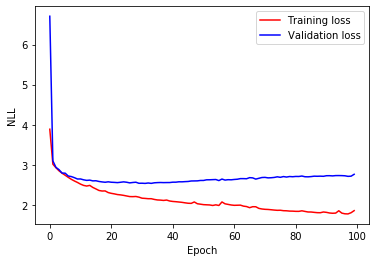

In [49]:
# Hyper-parameters
num_epochs = 100

# Initialize a new network
net = Net()

# Define a loss function and optimizer for this problem
# YOUR CODE HERE!
criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.2, weight_decay=1e-3)

def accuracy(ys, ts):
    predictions = torch.round(ys)
    correct_prediction = torch.eq(torch.round(outputs),targets)
    return torch.mean(correct_prediction.float())

# Track loss
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_training_acc = 0
    epoch_validation_loss = 0
    
    net.eval()
    for j in range(len(X_valid)):
        inputs = torch.Tensor(X_valid[j])
        targets = torch.Tensor(y_valid[j])
        # Forward pass
        outputs = net.forward(inputs)
        # Compute loss
        loss = criterion(outputs,targets)
        # Update loss
        epoch_validation_loss += loss.detach().numpy()
    
    net.train()
    for j in range(len(X_train)):
        inputs = torch.Tensor(X_train[j])
        targets = torch.Tensor(y_train[j])
        outputs = net.forward(inputs)
        # Compute loss
        loss = criterion(outputs,targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update loss
        epoch_training_loss += loss.detach().numpy()
        
    # Save loss for plot
    train_loss.append(epoch_training_loss/len(X_train))
    valid_loss.append(epoch_validation_loss/len(X_valid))

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i} \t train loss: {train_loss[-1]:.10f} \t valid loss: {valid_loss[-1]:.10f} \t valid acc:')



# Plot training and validation loss
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', label='Training loss',)
plt.plot(epoch, valid_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

In [50]:
outputs

tensor([[-8.4927e-02,  4.8047e-01,  1.0543e+00, -4.6603e-02,  2.9607e+00,
         -6.9327e-02, -2.0507e-02,  1.5457e-01, -3.0723e-01,  2.3066e-01,
          1.8279e-01,  1.9489e-01,  2.1139e-01,  6.1008e-02,  3.6674e-01,
          1.7034e+00,  2.6675e-01,  1.5536e-04,  9.1020e-02,  2.8562e-01,
          5.7715e-01,  6.4000e-02,  5.9982e-01, -3.2295e-01,  3.0422e-01,
          1.3716e+00,  9.6128e-01, -1.4311e-02, -2.5662e-01,  3.5696e-01,
          8.0740e-01, -1.9933e-01,  2.5804e-01,  3.1504e-01,  3.4176e-01,
          2.4478e-01,  3.1560e-01,  4.0748e-01, -1.6629e-01,  3.1888e-02,
          1.1665e-01,  2.2227e-01,  2.6124e+00,  3.3540e-01,  2.6063e-01,
          7.2059e-02,  5.8955e-01,  1.1118e+00,  1.3634e+00,  7.4465e-02,
          2.1837e-01,  6.7471e-01,  3.7679e+00,  1.4366e+00,  6.3748e-01,
         -1.8719e-01,  1.9663e-01, -8.1424e-03,  3.4253e-01,  1.1199e+00,
         -1.1796e-01, -7.6176e-02,  1.8923e-01,  3.6756e-02,  6.3886e-01,
          3.3710e-02, -3.1798e-02,  7.

In [51]:
targets

tensor([[ 0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1., 10.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,  0.,  2.,  1.,  2.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  2.,  0.,  2.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,
          4.,  0.]])

In [52]:
outputs-targets

tensor([[-8.4927e-02,  4.8047e-01,  1.0543e+00, -4.6603e-02, -1.0393e+00,
         -6.9327e-02, -2.0507e-02,  1.5457e-01, -3.0723e-01,  2.3066e-01,
          1.8279e-01,  1.9489e-01,  2.1139e-01,  6.1008e-02, -6.3326e-01,
         -8.2966e+00,  2.6675e-01,  1.5536e-04,  9.1020e-02,  2.8562e-01,
         -1.4229e+00, -1.9360e+00,  5.9982e-01, -3.2295e-01, -1.6958e+00,
          3.7160e-01, -1.0387e+00, -1.4311e-02, -2.5662e-01,  3.5696e-01,
          8.0740e-01, -1.9933e-01,  2.5804e-01,  3.1504e-01,  3.4176e-01,
         -1.7552e+00,  3.1560e-01,  4.0748e-01, -1.6629e-01,  3.1888e-02,
          1.1665e-01,  2.2227e-01,  1.6124e+00,  3.3540e-01,  2.6063e-01,
          7.2059e-02,  5.8955e-01,  1.1118e+00,  1.3634e+00,  7.4465e-02,
          2.1837e-01,  6.7471e-01, -4.2321e+00, -5.6343e-01,  6.3748e-01,
         -2.1872e+00,  1.9663e-01, -8.1424e-03,  3.4253e-01,  1.1989e-01,
         -1.1796e-01, -7.6176e-02,  1.8923e-01,  3.6756e-02, -2.3611e+00,
          3.3710e-02, -3.1798e-02,  7.